In [60]:
import pandas as pd
import matplotlib as matplotlib
import matplotlib.pyplot as plt
import matplotlib.style as style
plt.style.use('fivethirtyeight')

import warnings
warnings.filterwarnings(action='once')

import numpy as np
import statsmodels
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
import seaborn as sns
import scipy as stats

#TBATS forecasting methods
import tbats
from tbats import TBATS, BATS

#Auto arima/sarima package
import pmdarima as pm
from pmdarima.arima import auto_arima

#Facebook Prophet Package
from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation

#To save models as binary on disk
import pickle

print('Imports Complete')

Imports Complete


# The goal of this notebook was to identify the best type of forecasting model to use for forecasting all 800+ original time series by testing model performance across each community cluster created after applying network analysis/clustering
- Several model types were considered
     - SARIMA
         - Sarima was used as a benchmark standard forecasting method, but fails to capture the complex seasonality of the dataset due to only being able to incorporate one seasonality 
     - TBATS
         - TBATS can model complex seasonality as a fourier series, but is extremely computational expensive as it performs a black box grid search to optimize its parameters
         - The ability to model complex seasonality is important, as the rideshare datasets have both daily (24 hour) and weekly (168 hour) seasonality
     - Facebook Prophet
         - Prophet can also model complex seasonality, and was specifically made to handle long term, granular level data (i.e. hourly data) 

Read in the community cluster time series files

In [3]:
#Take in files for communities
com0=pd.read_csv(r'C:\Users\BRANDIN_HIRSCH\Desktop\df_community_0.csv')

com1=pd.read_csv(r'C:\Users\BRANDIN_HIRSCH\Desktop\df_community_1.csv')

com2=pd.read_csv(r'C:\Users\BRANDIN_HIRSCH\Desktop\df_community_2.csv')

com3=pd.read_csv(r'C:\Users\BRANDIN_HIRSCH\Desktop\df_community_3.csv')

community_names=[com0,com1,com2,com3]

for com in community_names:
    
    com['time']=pd.to_datetime(com['time'])
    
    com.set_index('time',inplace=True)
    
    
    


By plotting the first few weeks of each time series, we can see that rideshare volume in each community behaves similarly, but they are not exactly the same

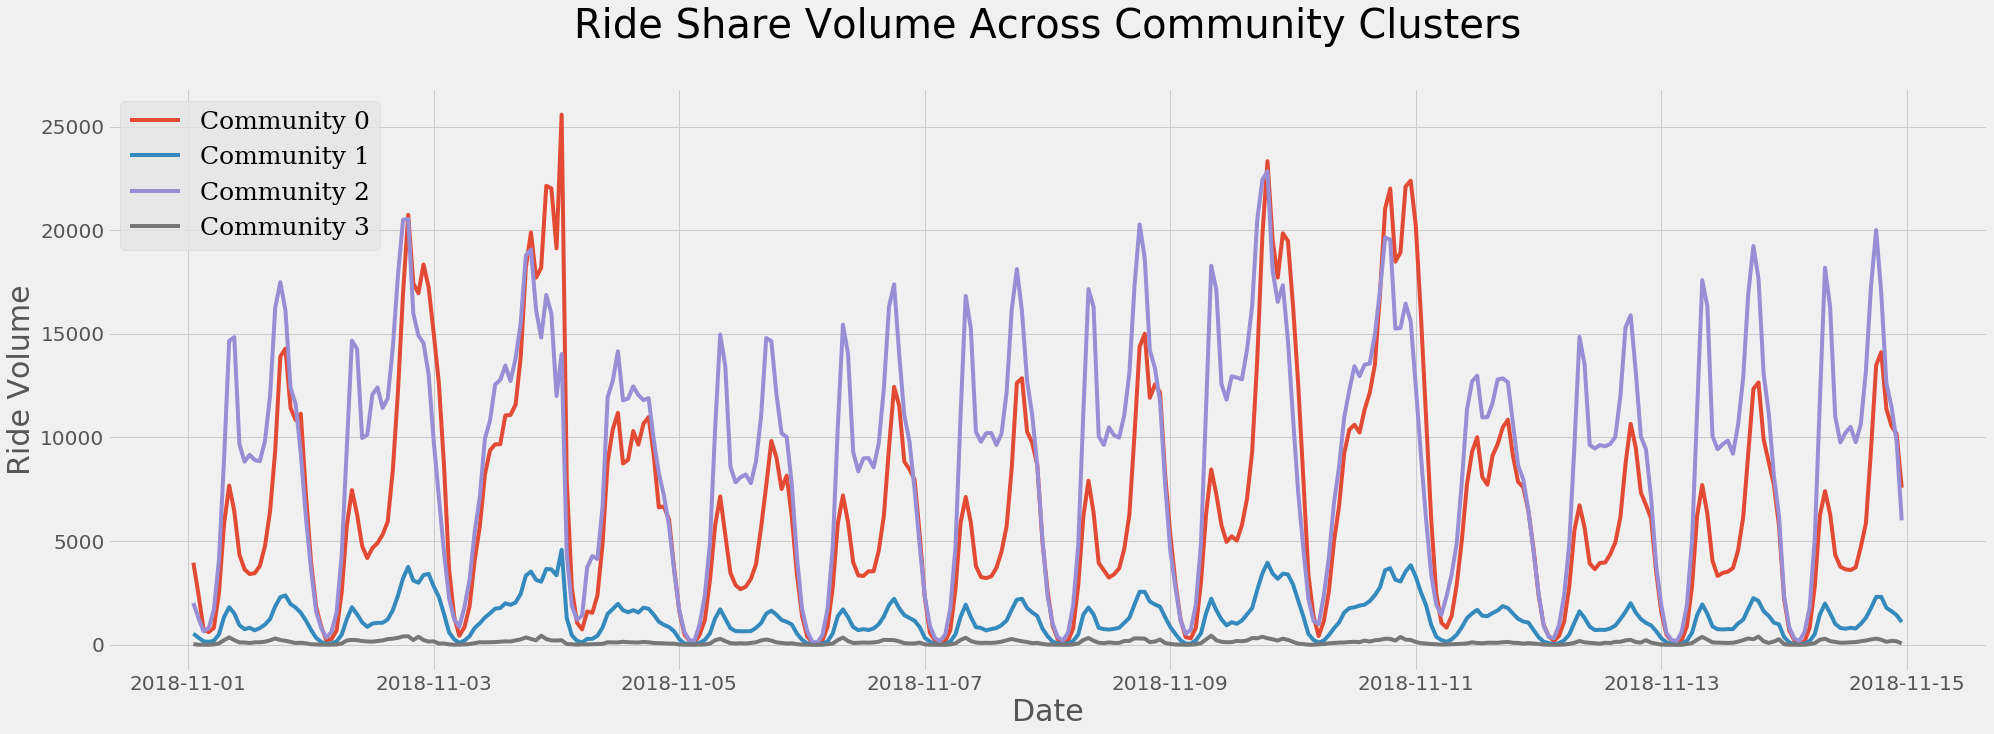

In [62]:
#Set axis size
fig, ax=plt.subplots(figsize=(30,10))

#Set plot style
style.use('ggplot')

matplotlib.rcParams['font.family'] = "serif"


all_communities=pd.DataFrame({'Community 0':com0.trip_count,'Community 1':com1.trip_count,'Community 2':com2.trip_count,'Community 3':com3.trip_count})
 
sns.lineplot(data=all_communities.iloc[1:336],dashes=False)

ax.set_title('Ride Share Volume Across Community Clusters',fontsize=40,pad=50)
    
    
ax.set_ylabel('Ride Volume',fontsize=30)
    
ax.set_xlabel('Date',fontsize=30)

for tick in ax.get_xticklabels():
        tick.set_fontsize(20) 
        tick.set_rotation(0)
        
for tick in ax.get_yticklabels():
        tick.set_fontsize(20)
        

plt.legend(loc='upper left',fontsize=25)


The Augmented Dickey Fuller Test has a null hypothesis that the series is NOT stationary. Below, you can see that the P-Values are all less than .05 signifying stationarity for each time series

In [6]:
def test_stationarity(timeseries):
    
    print('Results of Dickey-Fuller Test:')
    timeseries=timeseries.dropna()
    dftest = adfuller(timeseries.iloc[:,0].values, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
    
community_list=[com0,com1,com2,com3]

for community in community_list:
    test_stationarity(community)

Results of Dickey-Fuller Test:
Test Statistic                -7.946464e+00
p-value                        3.210133e-12
#Lags Used                     3.000000e+01
Number of Observations Used    3.593000e+03
Critical Value (1%)           -3.432171e+00
Critical Value (5%)           -2.862345e+00
Critical Value (10%)          -2.567198e+00
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                -7.293939e+00
p-value                        1.393779e-10
#Lags Used                     3.000000e+01
Number of Observations Used    3.593000e+03
Critical Value (1%)           -3.432171e+00
Critical Value (5%)           -2.862345e+00
Critical Value (10%)          -2.567198e+00
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                -5.829289e+00
p-value                        4.010254e-07
#Lags Used                     3.000000e+01
Number of Observations Used    3.593000e+03
Critical Value (1%)           -3.432171e+00
Critical Value (5%)           -2.862345e+

Here we create test sets consiting of the last 4 weeks of each series

In [7]:
#Community 0
com0_y = com0['trip_count']

com0_y_to_test = com0_y.iloc[(len(com0_y)-672):] # last 4 weeks for testing

#Community 1
com1_y = com1['trip_count']

com1_y_to_test = com1_y.iloc[(len(com1_y)-672):] # last 4 weeks for testing

#Community 2
com2_y = com2['trip_count']

com2_y_to_test = com2_y.iloc[(len(com2_y)-672):] # last 4 weeks for testing

#Community 3
com3_y = com3['trip_count']

com3_y_to_test = com3_y.iloc[(len(com3_y)-672):] # last 4 weeks for testing

To validate the models, I used walk forward validation, a technique where as time moves, new information is incorporated back into the model for training, showcasing how the model would perform in real time. 

Here I defined a set of functions to perform walk forward valdiation using TBATS

In [12]:
def tbats_walkforward_validation(community_df,period_length,num_periods,seasonal_periods=(0,0)):
       
    
    time_series=community_df
    
    #Extract a datetime index based on the test set this will be measured against (period length times the number of periods)
    time_index=time_series.iloc[len(time_series)-period_length*num_periods:].index
    

       
    cv_forecasts=[]
    
    #Loop through number of walk forward forecasts
    for i in range(num_periods,0,-1):
        
        #Create initial train series
        time_series_train= time_series.iloc[:(len(time_series)-(period_length*i))]
        
        #Instantiate new model (Prophet model variable must be cleared after each fit)
        estimator = TBATS(seasonal_periods=seasonal_periods)
    
        #Fit and Predict
        my_model = estimator.fit(time_series_train)      
               
        forecast=my_model.forecast(steps=period_length)
        
        forecast_df=pd.DataFrame({'forecast':forecast})
                
        #Append forecast
        cv_forecasts.append(forecast_df)
        
        print('1 week walked')
        
    cv_forecasts=pd.concat(cv_forecasts)
    
    #Set a datetime index based on the test set this will be measured against (period length times the number of periods)
    cv_forecasts.set_index(time_index,inplace=True)
      
    #Return list of dataframes with each walked forward forecast
    return cv_forecasts

Perform walkforward validation for TBATS, walking forward 4 weeks

In [11]:
tbats_walkforward_0=tbats_walkforward_validation(com0,168,4,seasonal_periods=(24,168))

tbats_walkforward_0.to_csv(r'C:\Users\BRANDIN_HIRSCH\Desktop\tbats_walkforward_community0.csv')

print(len(tbats_walkforward_0))

672


In [16]:
tbats_walkforward_1=tbats_walkforward_validation(com1,168,4,seasonal_periods=(24,168))

tbats_walkforward_1.to_csv(r'C:\Users\BRANDIN_HIRSCH\Desktop\tbats_walkforward_community1.csv')

print(len(tbats_walkforward_1))

1 week walked
1 week walked
1 week walked
1 week walked
672


In [19]:
tbats_walkforward_2=tbats_walkforward_validation(com2,168,4,seasonal_periods=(24,168))

tbats_walkforward_2.to_csv(r'C:\Users\BRANDIN_HIRSCH\Desktop\tbats_walkforward_community2.csv')

print(len(tbats_walkforward_2))

1 week walked
1 week walked
1 week walked
1 week walked
672


In [20]:
tbats_walkforward_3=tbats_walkforward_validation(com3,168,4,seasonal_periods=(24,168))

tbats_walkforward_3.to_csv(r'C:\Users\BRANDIN_HIRSCH\Desktop\tbats_walkforward_community3.csv')

print(len(tbats_walkforward_3))

1 week walked
1 week walked
1 week walked
1 week walked
672


Plot the TBATS forecasts against the test sets for each community

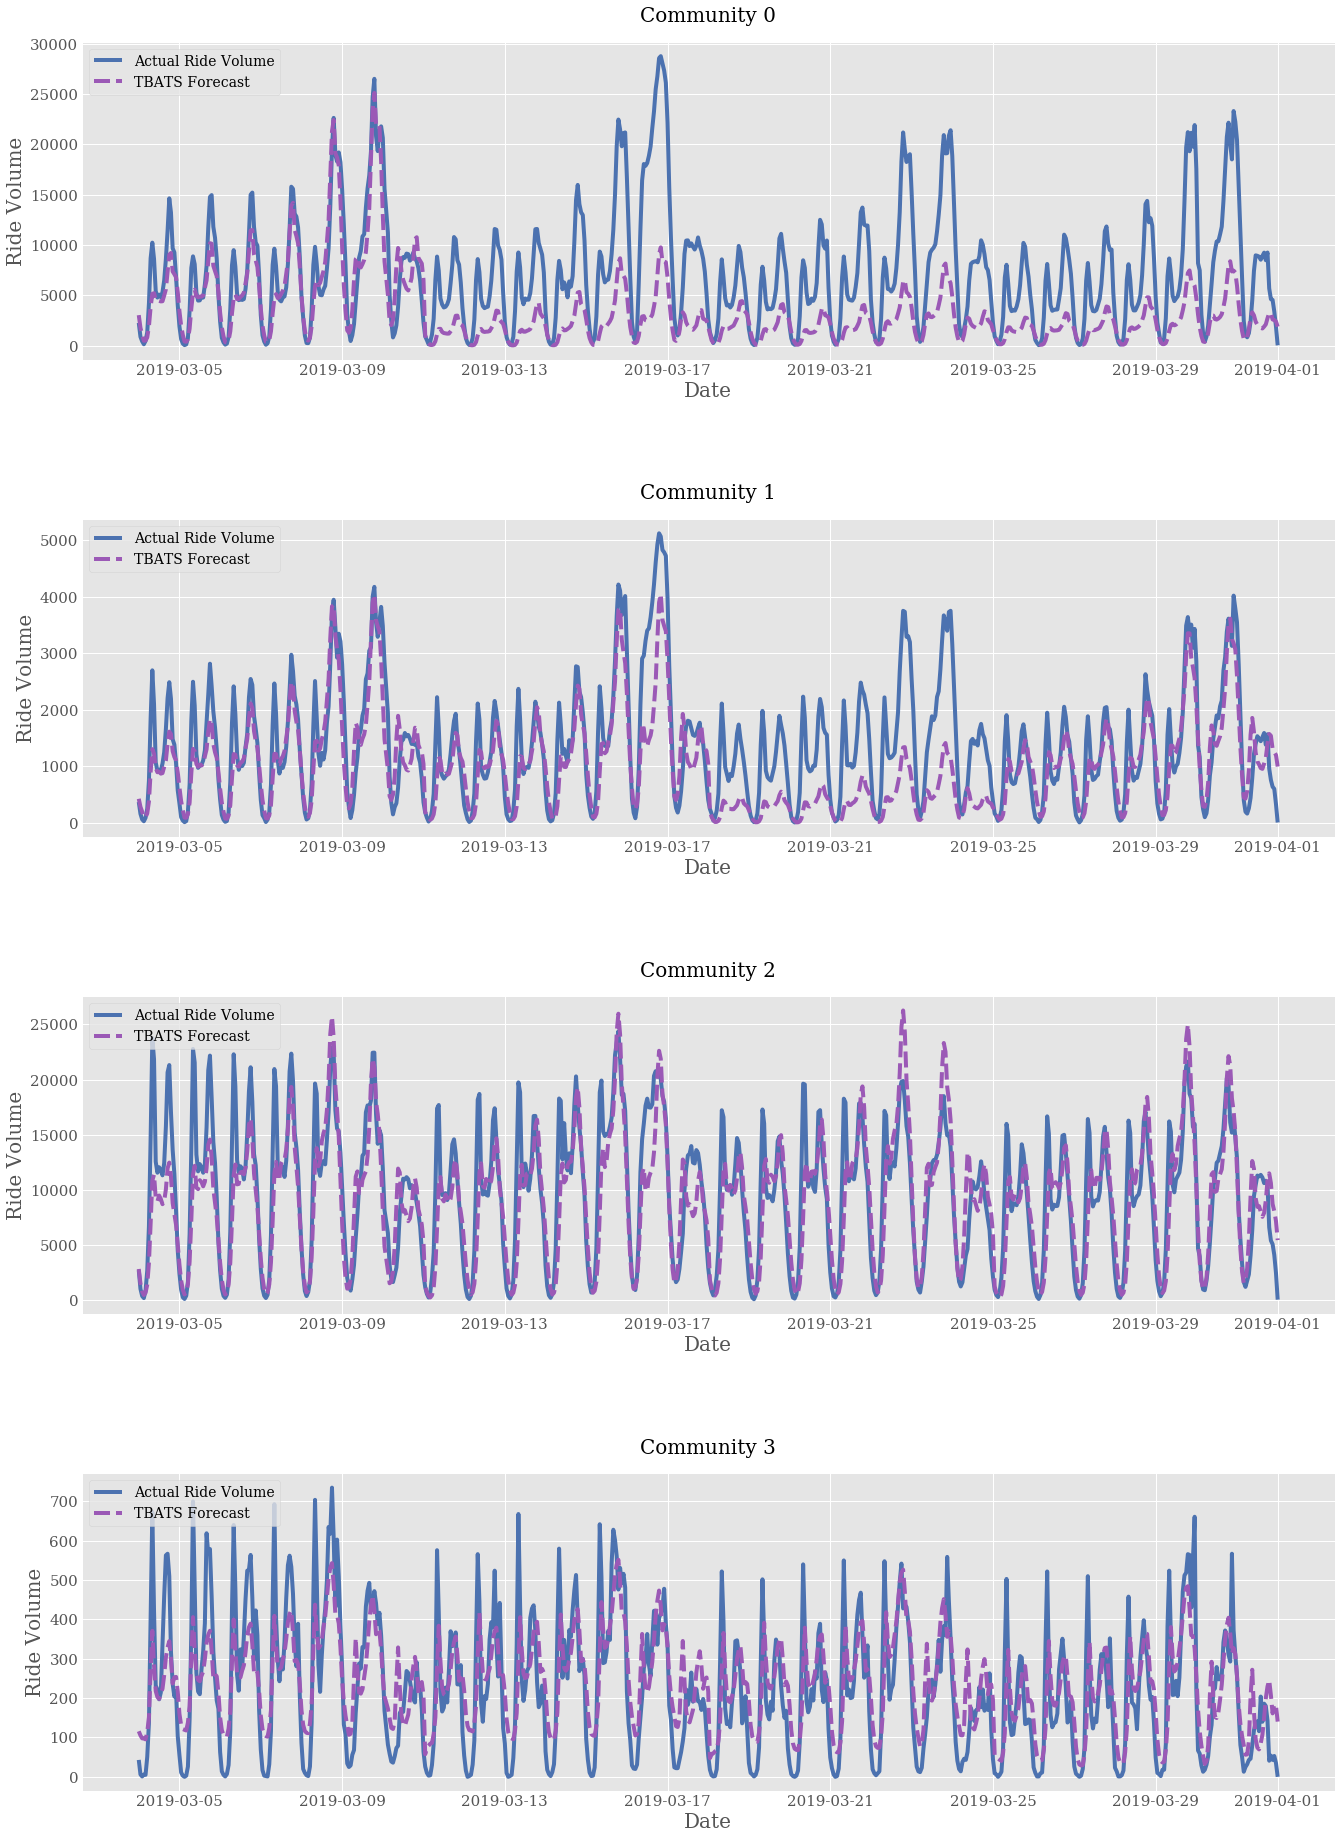

In [103]:
#Plot forecast and actual values for last 4 weeks of dataset 

fig, (ax1,ax2,ax3,ax4)=plt.subplots(4,1,figsize=(20,30))

fig.subplots_adjust(hspace=.5)
style.use('ggplot')

plt.xticks(rotation=90)

#Function to plot TBATS test results
def plot_forecasts(actual,forecast,ax,title):
    
    comparison_df=pd.DataFrame(data={'Actual Ride Volume':actual,'TBATS Forecast':forecast})
           
    sns.lineplot(data=comparison_df,ax=ax,palette = sns.color_palette(["#4c72b0","#9b59b6"]))
      
    
    ax.legend(loc='upper left',fontsize=14)
    
    ax.set_title(title,fontsize=20,pad=20)
    
    
    ax.set_ylabel('Ride Volume',fontsize=20)
    
    ax.set_xlabel('Date',fontsize=20)

    for tick in ax.get_xticklabels():
        tick.set_fontsize(15) 
        tick.set_rotation(0)
        
    for tick in ax.get_yticklabels():
        tick.set_fontsize(15)
  

            
#Plot for community 0
plot_forecasts(com0_y_to_test,tbats_walkforward_0.forecast,ax1,'Community 0')
    
#Plot for community 1
plot_forecasts(com1_y_to_test,tbats_walkforward_1.forecast,ax2,'Community 1')

#Plot for community 2
plot_forecasts(com2_y_to_test,tbats_walkforward_2.forecast,ax3,'Community 2')

#Plot for community 3
plot_forecasts(com3_y_to_test,tbats_walkforward_3.forecast,ax4,'Community 3')


Here I used Auto-Arima to identify the most optimal SARIMA parameters for each community

In [10]:
com0_stepwise_sarima = pm.auto_arima(com0_y_to_train, start_p=1, start_q=1,
                             max_p=3, max_q=3, m=24, d=0, D=0,
                             start_P=0, seasonal=True,
                             trace=True, information_criterion='bic',
                             error_action='ignore',  # don't want to know if an order does not work
                             suppress_warnings=True,  # don't want convergence warnings
                             stepwise=True)  # set to stepwise


com1_stepwise_sarima = pm.auto_arima(com1_y_to_train, start_p=1, start_q=1,
                             max_p=3, max_q=3, m=24, d=0, D=0,
                             start_P=0, seasonal=True,
                             trace=True,information_criterion='bic',
                             error_action='ignore',  # don't want to know if an order does not work
                             suppress_warnings=True,  # don't want convergence warnings
                             stepwise=True)  # set to stepwise

com2_stepwise_sarima = pm.auto_arima(com2_y_to_train, start_p=1, start_q=1,
                             max_p=3, max_q=3, m=24, d=0, D=0,
                             start_P=0, seasonal=True,
                             trace=True,information_criterion='bic',
                             error_action='ignore',  # don't want to know if an order does not work
                             suppress_warnings=True,  # don't want convergence warnings
                             stepwise=True)  # set to stepwise

com3_stepwise_sarima = pm.auto_arima(com3_y_to_train, start_p=1, start_q=1,
                             max_p=3, max_q=3, m=24, d=0, D=0,
                             start_P=0, seasonal=True,
                             trace=True,information_criterion='bic', 
                             error_action='ignore',  # don't want to know if an order does not work
                             suppress_warnings=True,  # don't want convergence warnings
                             stepwise=True)  # set to stepwise

Fit ARIMA: order=(1, 0, 1) seasonal_order=(0, 0, 1, 24); AIC=57111.666, BIC=57142.156, Fit time=7.264 seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(0, 0, 0, 24); AIC=66071.175, BIC=66083.372, Fit time=0.046 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(1, 0, 0, 24); AIC=57888.317, BIC=57912.709, Fit time=11.392 seconds
Fit ARIMA: order=(0, 0, 1) seasonal_order=(0, 0, 1, 24); AIC=60796.019, BIC=60820.412, Fit time=7.792 seconds
Fit ARIMA: order=(1, 0, 1) seasonal_order=(1, 0, 1, 24); AIC=56315.391, BIC=56351.979, Fit time=15.667 seconds
Fit ARIMA: order=(1, 0, 1) seasonal_order=(1, 0, 0, 24); AIC=56763.988, BIC=56794.479, Fit time=12.790 seconds
Fit ARIMA: order=(1, 0, 1) seasonal_order=(1, 0, 2, 24); AIC=56391.986, BIC=56434.672, Fit time=71.306 seconds
Fit ARIMA: order=(1, 0, 1) seasonal_order=(0, 0, 0, 24); AIC=57844.233, BIC=57868.625, Fit time=1.935 seconds
Fit ARIMA: order=(1, 0, 1) seasonal_order=(2, 0, 2, 24); AIC=56403.208, BIC=56451.992, Fit time=68.983 seconds
Fit A

Fit ARIMA: order=(3, 0, 1) seasonal_order=(2, 0, 1, 24); AIC=36336.131, BIC=36391.013, Fit time=85.520 seconds
Fit ARIMA: order=(2, 0, 2) seasonal_order=(2, 0, 1, 24); AIC=36086.387, BIC=36141.269, Fit time=75.495 seconds
Fit ARIMA: order=(3, 0, 3) seasonal_order=(2, 0, 1, 24); AIC=36370.669, BIC=36437.748, Fit time=90.622 seconds
Fit ARIMA: order=(2, 0, 2) seasonal_order=(1, 0, 1, 24); AIC=36237.969, BIC=36286.754, Fit time=20.336 seconds
Fit ARIMA: order=(2, 0, 2) seasonal_order=(2, 0, 0, 24); AIC=36534.633, BIC=36583.417, Fit time=79.603 seconds
Fit ARIMA: order=(2, 0, 2) seasonal_order=(2, 0, 2, 24); AIC=36250.370, BIC=36311.350, Fit time=99.615 seconds
Fit ARIMA: order=(2, 0, 2) seasonal_order=(1, 0, 0, 24); AIC=36643.116, BIC=36685.802, Fit time=20.745 seconds
Fit ARIMA: order=(1, 0, 2) seasonal_order=(2, 0, 1, 24); AIC=36617.251, BIC=36666.035, Fit time=84.134 seconds
Fit ARIMA: order=(2, 0, 3) seasonal_order=(2, 0, 1, 24); AIC=36283.592, BIC=36344.572, Fit time=99.074 seconds
T

In [153]:
#Print the details of the sarima models with the lowest BIC found by auto-arima

print(com0_stepwise_sarima)

print(com1_stepwise_sarima)

print(com2_stepwise_sarima)

print(com3_stepwise_sarima)

ARIMA(callback=None, disp=0, maxiter=None, method=None, order=(1, 0, 1),
   out_of_sample_size=0, scoring='mse', scoring_args={},
   seasonal_order=(1, 0, 1, 24), solver='lbfgs', start_params=None,
   suppress_warnings=True, transparams=True, trend=None,
   with_intercept=True)
ARIMA(callback=None, disp=0, maxiter=None, method=None, order=(1, 0, 1),
   out_of_sample_size=0, scoring='mse', scoring_args={},
   seasonal_order=(1, 0, 2, 24), solver='lbfgs', start_params=None,
   suppress_warnings=True, transparams=True, trend=None,
   with_intercept=True)
ARIMA(callback=None, disp=0, maxiter=None, method=None, order=(1, 0, 2),
   out_of_sample_size=0, scoring='mse', scoring_args={},
   seasonal_order=(1, 0, 0, 24), solver='lbfgs', start_params=None,
   suppress_warnings=True, transparams=True, trend=None,
   with_intercept=True)
ARIMA(callback=None, disp=0, maxiter=None, method=None, order=(2, 0, 2),
   out_of_sample_size=0, scoring='mse', scoring_args={},
   seasonal_order=(2, 0, 1, 24), 

Define a function to perform walkforward valdiation with SARIMA models

In [66]:
def sarima_walkforward_validation(community_df,period_length,num_periods,order=(0,0,0),seasonal_order=(0,0,0,0)):
    
    
    time_series=community_df
    
    #Extract a datetime index based on the test set this will be measured against (period length times the number of periods)
    time_index=time_series.iloc[len(time_series)-period_length*num_periods:].index


       
    cv_forecasts=[]
    
    #Loop through number of walk forward forecasts
    for i in range(num_periods,0,-1):
        
        #Create initial train series
        time_series_train= time_series.iloc[:(len(time_series)-(period_length*i))]
        
        
        #Instantiate new model (Prophet model variable must be cleared after each fit)
        my_model=sm.tsa.statespace.SARIMAX(endog=time_series_train,order=order,seasonal_order=seasonal_order,initialization='approximate_diffuse')
       
    
        #Fit and Predict
        results=my_model.fit()
        
        forecast=results.forecast(period_length)
        
        forecast_df=pd.DataFrame({'forecast':forecast})
        
        
        #Append forecast
        cv_forecasts.append(forecast_df)
        
        print('{} weeks left'.format(i))
        
    cv_forecasts=pd.concat(cv_forecasts)
    
    #Set a datetime index based on the test set this will be measured against (period length times the number of periods)
    cv_forecasts.set_index(time_index,inplace=True)
    
    #Set negative values to 0
    for col in cv_forecasts.columns:
        cv_forecasts[col][cv_forecasts[col] < 0] = 0

    #Return list of dataframes with each walked forward forecast
    return cv_forecasts

Walk forward 4 weeks using SARIMA models

In [67]:
sarima_walkforward_0=sarima_walkforward_validation(com0,168,4,order=(1,0,1),seasonal_order=(1,0,1,24))

sarima_walkforward_1=sarima_walkforward_validation(com1,168,4,order=(1,0,1),seasonal_order=(1,0,2,24))

sarima_walkforward_2=sarima_walkfor0ward_validation(com2,168,4,order=(1,0,2),seasonal_order=(1,0,0,24))

sarima_walkforward_3=sarima_walkforward_validation(com3,168,4,order=(2,0,2),seasonal_order=(2,0,1,24))





C:\Users\brandin_hirsch\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)
C:\Users\brandin_hirsch\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:191: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  start=index[0], end=index[-1], freq=freq)
C:\Users\brandin_hirsch\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1051: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if self.state_error and params_variance == []:


4 week(s) walked


C:\Users\brandin_hirsch\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\brandin_hirsch\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


3 week(s) walked
2 week(s) walked
1 week(s) walked
4 week(s) walked
3 week(s) walked
2 week(s) walked
1 week(s) walked
4 week(s) walked
3 week(s) walked
2 week(s) walked
1 week(s) walked


C:\Users\brandin_hirsch\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


4 week(s) walked
3 week(s) walked
2 week(s) walked
1 week(s) walked


Plot the SARIMA forecasts against the test sets for each community

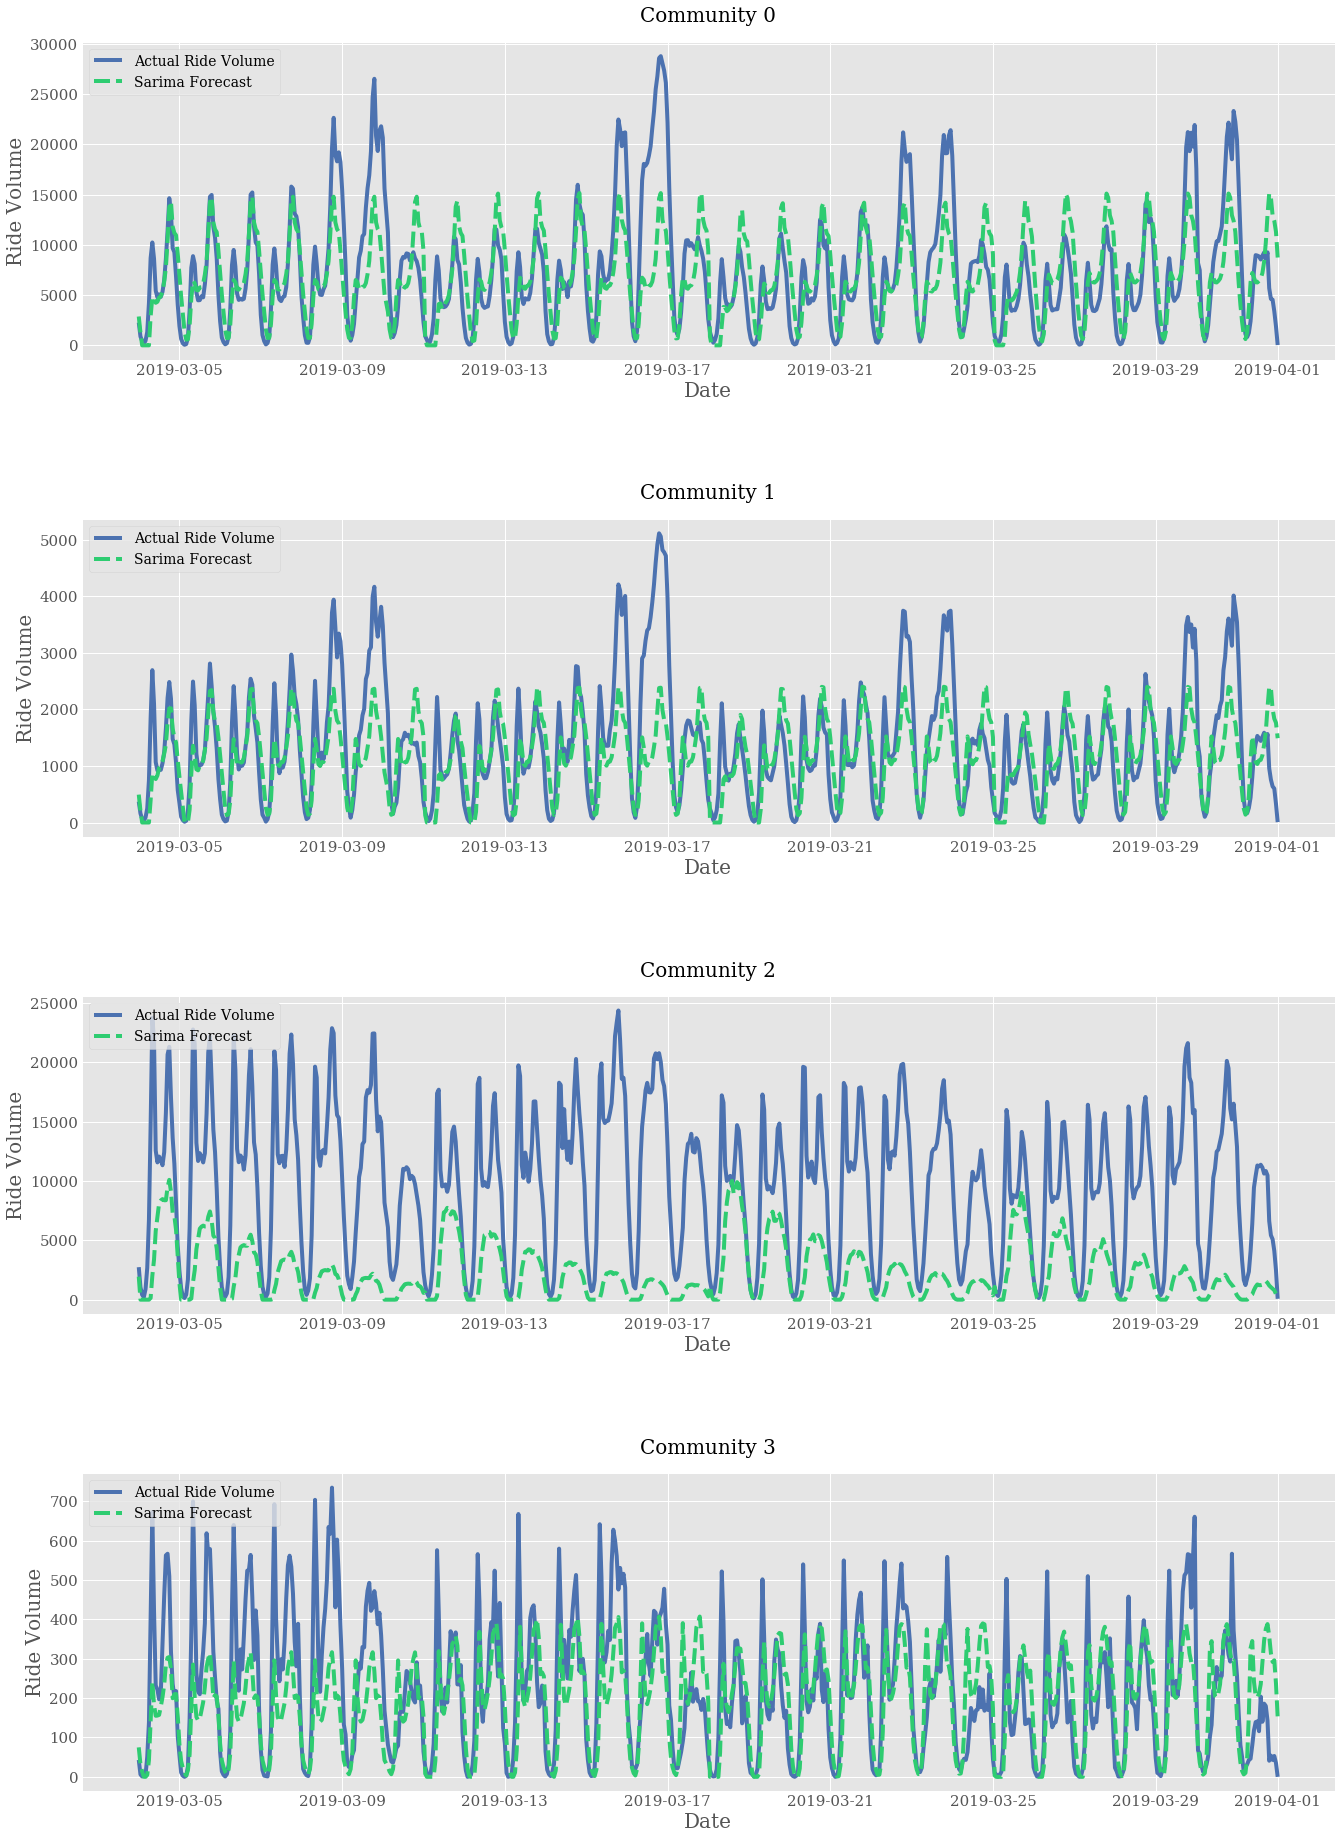

In [101]:
#Plot forecast and actual values for last 4 weeks of dataset 

fig, (ax1,ax2,ax3,ax4)=plt.subplots(4,1,figsize=(20,30))

fig.subplots_adjust(hspace=.5)
style.use('ggplot')

plt.xticks(rotation=90)

#Function to plot TBATS test results
def plot_forecasts(actual,forecast,ax,title):
    
    comparison_df=pd.DataFrame(data={'Actual Ride Volume':actual,'Sarima Forecast':forecast})
           
    sns.lineplot(data=comparison_df,ax=ax,palette = sns.color_palette(["#4c72b0","#2ecc71"]))
      
    
    ax.legend(loc='upper left',fontsize=14)
    
    ax.set_title(title,fontsize=20,pad=20)
    
    
    ax.set_ylabel('Ride Volume',fontsize=20)
    
    ax.set_xlabel('Date',fontsize=20)

    for tick in ax.get_xticklabels():
        tick.set_fontsize(15) 
        tick.set_rotation(0)
        
    for tick in ax.get_yticklabels():
        tick.set_fontsize(15)
  
            
#Plot for community 0
plot_forecasts(com0_y_to_test,sarima_walkforward_0.forecast,ax1,'Community 0')
    
#Plot for community 1
plot_forecasts(com1_y_to_test,sarima_walkforward_1.forecast,ax2,'Community 1')

#Plot for community 2
plot_forecasts(com2_y_to_test,sarima_walkforward_2.forecast,ax3,'Community 2')

#Plot for community 3
plot_forecasts(com3_y_to_test,sarima_walkforward_3.forecast,ax4,'Community 3')




Define a function to perform walk forward validation using Facebook's Prophet module

In [84]:
def prophet_walkforward_validation(community_df,period_length,num_periods):
    
    
    
    #Convert time series to FB Prophet format
    time_series=community_df.reset_index()
    
    time_series.columns=['ds','y'] #time series should be a dataframe with two columns, time and values
    
    cv_forecasts=[]
    
    #Loop through number of walk forward forecasts
    for i in range(num_periods,0,-1):
        
        #Create initial train series
        time_series_train= time_series.iloc[:(len(time_series)-(period_length*i))]   
        
        #Instantiate new model (Prophet model variable must be cleared after each fit)
        my_model=[]
        
        my_model=Prophet(weekly_seasonality=50)
        
        my_model.add_country_holidays(country_name='US')
        
    
        #Fit and Predict
        my_model.fit(time_series_train)
        
        future_dates = my_model.make_future_dataframe(periods=168, freq='1h')
    
        forecast = my_model.predict(future_dates)
    
    
        forecast_df=forecast[['yhat','ds']]
    
    
        forecast_df=forecast_df.set_index('ds')
    
    
        forecast_df=forecast_df.iloc[len(forecast_df)-period_length:]
    
        #Append forecast
        cv_forecasts.append(forecast_df)
        
        print('{} weeks left'.format(i-1))
        
    
    #Return list of dataframes with each walked forward forecast
    return pd.concat(cv_forecasts)

Walk forward 4 weeks using Prophet

In [85]:
prophet_walkforward_0=prophet_walkforward_validation(com0,168,4)

prophet_walkforward_1=prophet_walkforward_validation(com1,168,4)

prophet_walkforward_2=prophet_walkforward_validation(com2,168,4)

prophet_walkforward_3=prophet_walkforward_validation(com3,168,4)


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


4 weeks left


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3 weeks left


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


2 weeks left


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


1 weeks left


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


4 weeks left


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3 weeks left


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


2 weeks left


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


1 weeks left


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


4 weeks left


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3 weeks left


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


2 weeks left


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


1 weeks left


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


4 weeks left


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3 weeks left


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


2 weeks left
1 weeks left


Plot the Prophet forecasts against the test sets for each community

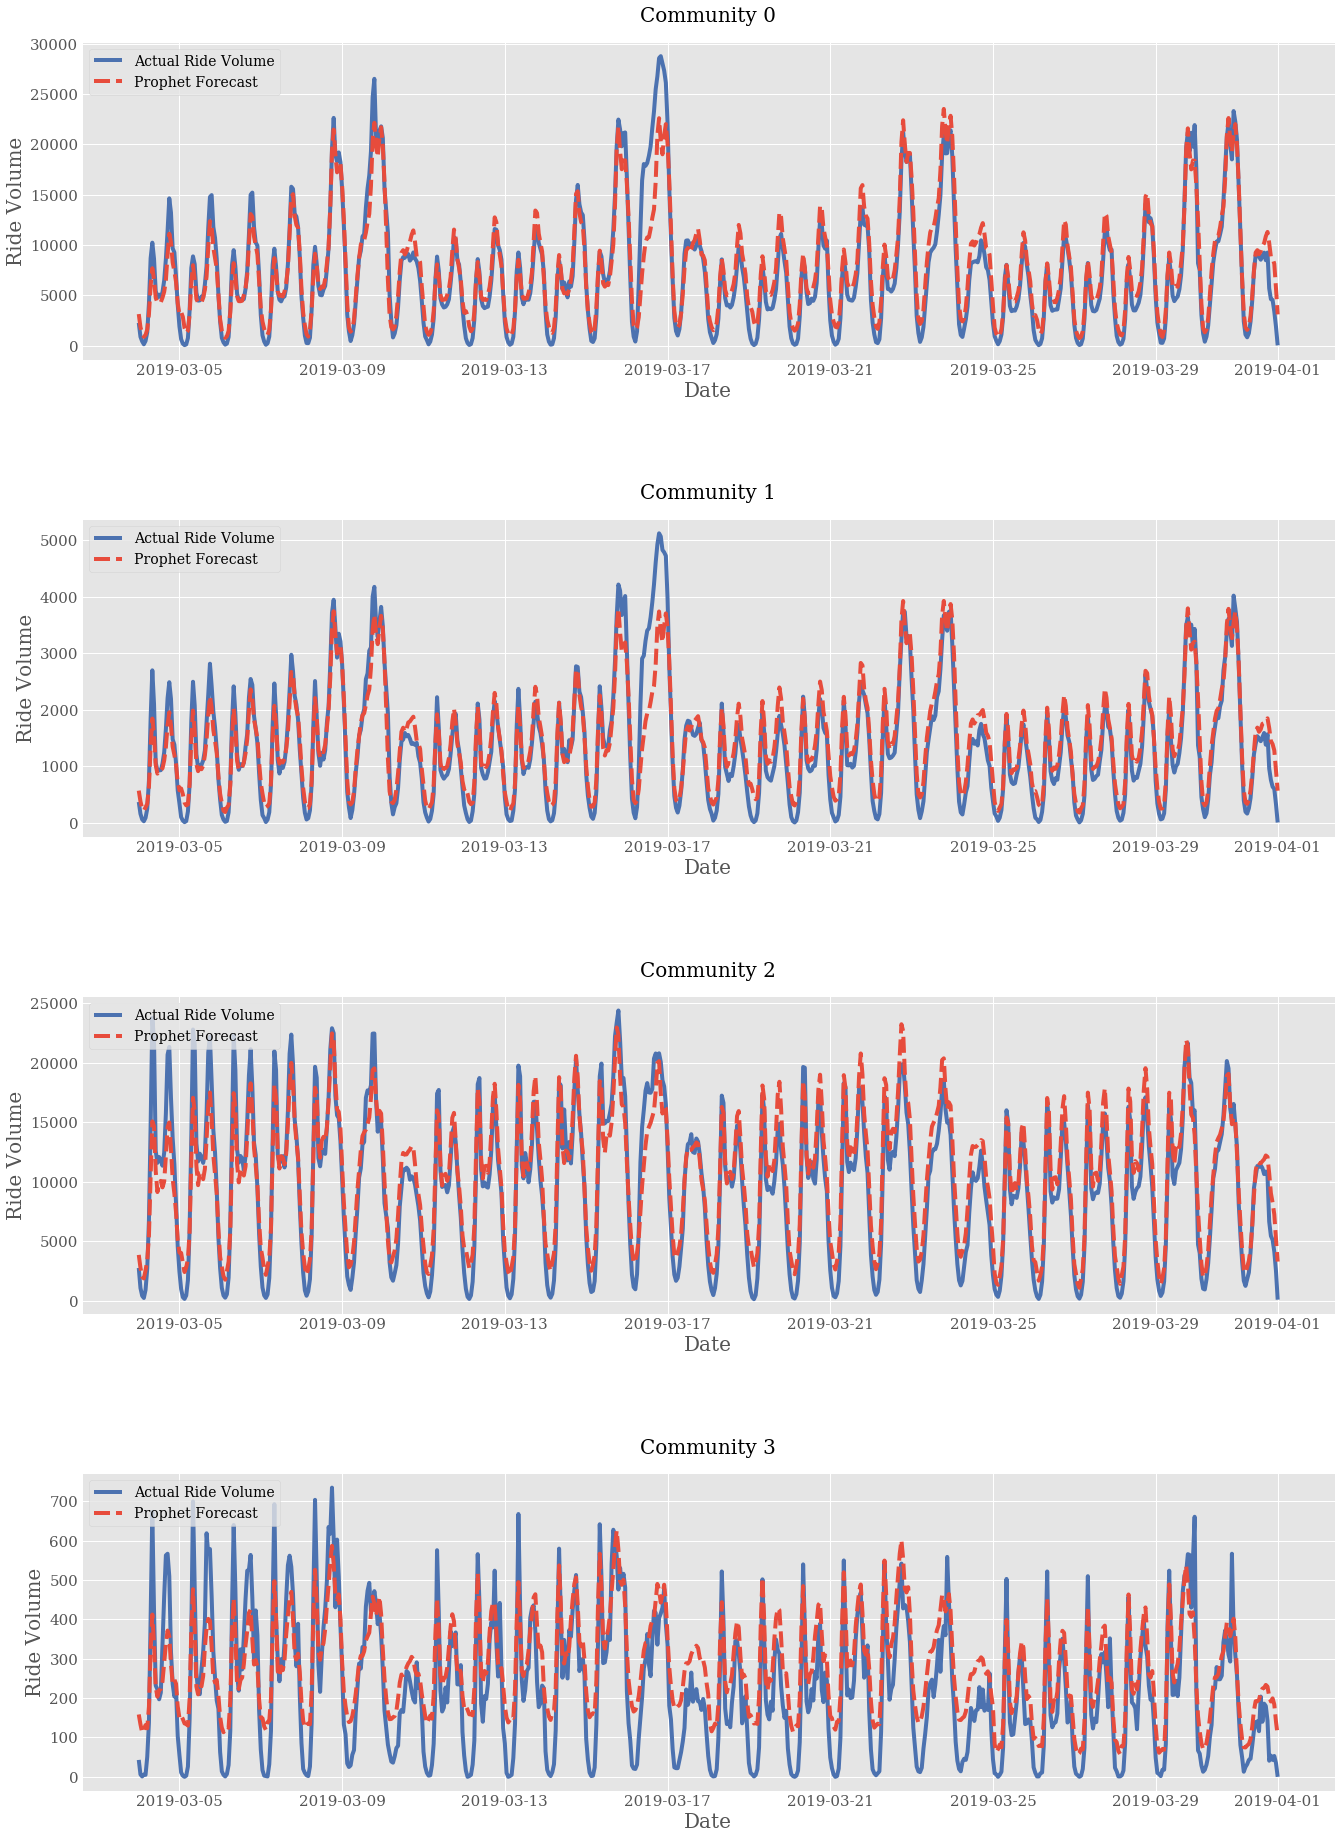

In [100]:
#Plot forecast and actual values for last 4 weeks of dataset 

fig, (ax1,ax2,ax3,ax4)=plt.subplots(4,1,figsize=(20,30))

fig.subplots_adjust(hspace=.5)
style.use('ggplot')

plt.xticks(rotation=90)

#Function to plot Prophet test results
def plot_forecasts(actual,forecast,ax,title):
    
    comparison_df=pd.DataFrame(data={'Actual Ride Volume':actual,'Prophet Forecast':forecast})
           
    sns.lineplot(data=comparison_df,ax=ax,palette = sns.color_palette(["#4c72b0","#e74c3c"]))
      
    
    ax.legend(loc='upper left',fontsize=14)
    
    ax.set_title(title,fontsize=20,pad=20)
    
    
    ax.set_ylabel('Ride Volume',fontsize=20)
    
    ax.set_xlabel('Date',fontsize=20)

    for tick in ax.get_xticklabels():
        tick.set_fontsize(15) 
        tick.set_rotation(0)
        
    for tick in ax.get_yticklabels():
        tick.set_fontsize(15)
  
            
#Plot for community 0
plot_forecasts(com0_y_to_test,prophet_walkforward_0.yhat,ax1,'Community 0')
    
#Plot for community 1
plot_forecasts(com1_y_to_test,prophet_walkforward_1.yhat,ax2,'Community 1')

#Plot for community 2
plot_forecasts(com2_y_to_test,prophet_walkforward_2.yhat,ax3,'Community 2')

#Plot for community 3
plot_forecasts(com3_y_to_test,prophet_walkforward_3.yhat,ax4,'Community 3')


Create functions and dataframes to calculate and hold RMSE scores for each of the models 

In [213]:
# Function to Calculate Accuracy metrics
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    
    return rmse


#Get list of RMSE for Com0
all_forecast_com0=[tbats_walkforward_0.forecast,sarima_walkforward_0.forecast,prophet_walkforward_0.yhat]

com0_rmse=[]

for f in all_forecast_com0:
    com0_rmse.append(forecast_accuracy(f,com0_y_to_test))

#Get list of RMSE for Com1
all_forecast_com1=[tbats_walkforward_1.forecast,sarima_walkforward_1.forecast,prophet_walkforward_1.yhat]

com1_rmse=[]

for f in all_forecast_com1:
    com1_rmse.append(forecast_accuracy(f,com1_y_to_test))

    
#Get list of RMSE for Com2
all_forecast_com2=[tbats_walkforward_2.forecast,sarima_walkforward_2.forecast,prophet_walkforward_2.yhat]

com2_rmse=[]

for f in all_forecast_com2:
    com2_rmse.append(forecast_accuracy(f,com2_y_to_test))

#Get list of RMSE for Com3
all_forecast_com3=[tbats_walkforward_3.forecast,sarima_walkforward_3.forecast,prophet_walkforward_3.yhat]

com3_rmse=[]

for f in all_forecast_com3:
    com3_rmse.append(forecast_accuracy(f,com3_y_to_test))




In [214]:
#Create dataframes of all accuracy metrics for each community for plotting
com0_rmse_df=pd.DataFrame() 

com1_rmse_df=pd.DataFrame()    

com2_rmse_df=pd.DataFrame()    

com3_rmse_df=pd.DataFrame() 

#List of RMSE lists
accuracy_df_list=[com0_rmse_df,com1_rmse_df,com2_rmse_df,com3_rmse_df]

for df in accuracy_df_list:
    df['model']=['TBATS','Sarima','Prophet']

com0_rmse_df['rmse']=com0_rmse

com1_rmse_df['rmse']=com1_rmse

com2_rmse_df['rmse']=com2_rmse

com3_rmse_df['rmse']=com3_rmse

Plot RMSE scores for each model forecast by community cluster
- Below shows that in each community, Facebook's Prophet had the lowest RMSE score after walk forward validation.
- It makes sense that Sarima would have some of the worst RMSE metrics due to not being able to model the weekly seasonality in the data
- I supsect Prophet beat out TBATS due to being purpose made for long term, hourly data as well as being able to adapt to slight changes in trends across the weeks

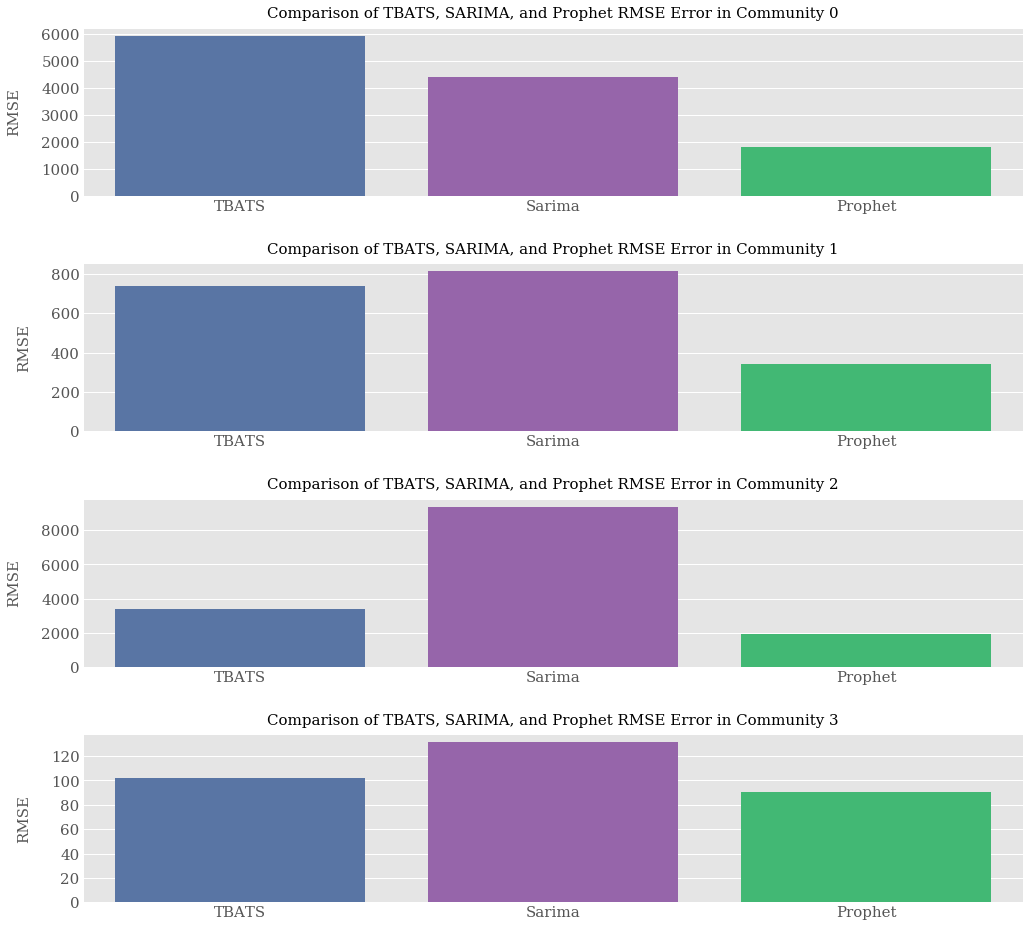

In [215]:
fig,(ax1,ax2,ax3,ax4)=plt.subplots(4,1,figsize=(15,15))
fig.subplots_adjust(hspace=.4)
style.use('ggplot')


#Function to plot Prophet test results
def plot_errors(error_df,ax,title): 
        
    sns.barplot(x='model',y='rmse',data=error_df,ax=ax,palette = sns.color_palette(["#4c72b0",'#9b59b6','#2ecc71' ,"#e74c3c"]))
    
    ax.set_title(title,fontsize=15,pad=10)

    
    ax.set_ylabel('RMSE',fontsize=15,labelpad=20)
    
    ax.set_xlabel('',fontsize=20,labelpad=20)
    
    for tick in ax.get_xticklabels():
        tick.set_fontsize(15) 
        tick.set_rotation(0)
        
    for tick in ax.get_yticklabels():
        tick.set_fontsize(15)
  
    
    


plot_errors(com0_rmse_df,ax1, 'Comparison of TBATS, SARIMA, and Prophet RMSE Error in Community 0')

plot_errors(com1_rmse_df,ax2, 'Comparison of TBATS, SARIMA, and Prophet RMSE Error in Community 1')

plot_errors(com2_rmse_df,ax3, 'Comparison of TBATS, SARIMA, and Prophet RMSE Error in Community 2')

plot_errors(com3_rmse_df,ax4, 'Comparison of TBATS, SARIMA, and Prophet RMSE Error in Community 3')



Going forward, I will use Prophet with optimized parameters to create hourly forecasts for the 800+ census tracts in Chicago
- Below I'll plot the forecasts for community cluster 0 just to visualize it.

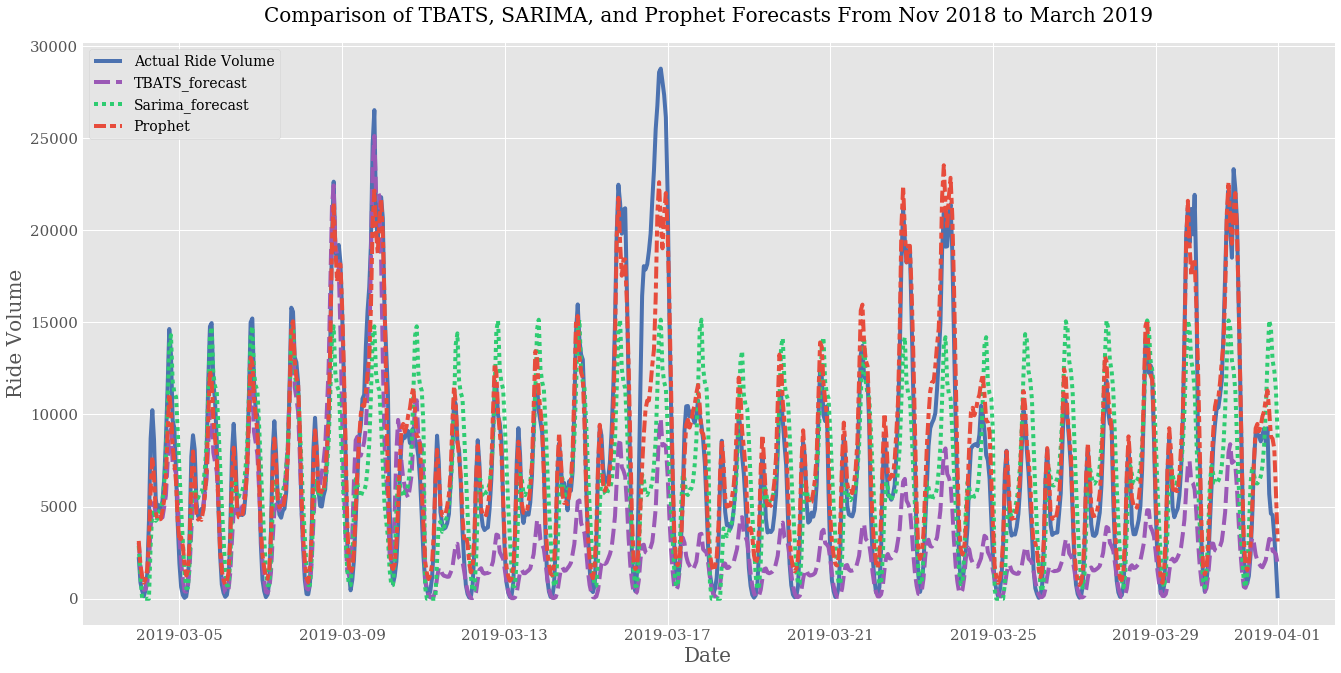

In [212]:
all_forecast_comparison=pd.DataFrame(data={'Actual Ride Volume':com0_y_to_test,'TBATS_forecast':tbats_walkforward_0.forecast,'Sarima_forecast':sarima_walkforward_0.forecast,'Prophet':prophet_walkforward_0.yhat})

fig,ax=plt.subplots(figsize=(20,10))

sns.lineplot(data=all_forecast_comparison,ax=ax,palette = sns.color_palette(["#4c72b0",'#9b59b6','#2ecc71' ,"#e74c3c"]))

ax.legend(loc='upper left',fontsize=14)
    
ax.set_title('Comparison of TBATS, SARIMA, and Prophet Forecasts From Nov 2018 to March 2019',fontsize=20,pad=20)
        
ax.set_ylabel('Ride Volume',fontsize=20)
    
ax.set_xlabel('Date',fontsize=20)

for tick in ax.get_xticklabels():
        tick.set_fontsize(15) 
        tick.set_rotation(0)
        
for tick in ax.get_yticklabels():
        tick.set_fontsize(15)


# Export forecasts to CSV to save for later 

In [122]:
sarima_walkforward_0.to_csv(r'C:\Users\BRANDIN_HIRSCH\Desktop\SARIMA_community0.csv')

sarima_walkforward_1.to_csv(r'C:\Users\BRANDIN_HIRSCH\Desktop\SARIMA_community1.csv')

sarima_walkforward_2.to_csv(r'C:\Users\BRANDIN_HIRSCH\Desktop\SARIMA_community2.csv')

sarima_walkforward_3.to_csv(r'C:\Users\BRANDIN_HIRSCH\Desktop\SARIMA_community3.csv')

In [123]:
prophet_walkforward_0.to_csv(r'C:\Users\BRANDIN_HIRSCH\Desktop\prophet_community0.csv')

prophet_walkforward_1.to_csv(r'C:\Users\BRANDIN_HIRSCH\Desktop\prophet_community1.csv')

prophet_walkforward_2.to_csv(r'C:\Users\BRANDIN_HIRSCH\Desktop\prophet_community2.csv')

prophet_walkforward_3.to_csv(r'C:\Users\BRANDIN_HIRSCH\Desktop\prophet_community3.csv')